### Introduction

TODO

### Preparation

Import required libraries:

In [115]:
# Import required libraries
import pandas as pd
import numpy as np
import numpy.random as nr
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.stats.weightstats as ws

from sklearn.preprocessing import scale
from statistics import mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Set global options:

In [3]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Function declarations:

In [105]:
# The following functions are from DataScience410/Lecture4/HypothesisTesting_Distributions.ipynb

# Perform a Q-Q plot
def qq_plot(vec1, vec2):
    plt.figure(figsize=(6, 6)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot

# Perform a cumulative distribution plot
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p)
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'yellow')
    plt.scatter(data_sorted, p, color = 'green')
    
# Perform a Kolmogorov-Smirnov Test
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

# The following functions are from DataScience410/Lecture4/HypothesisTesting_TestsOnMeans

# Perform a two-sided t-test on sample means with summary statistics
def t_test(a, b, alpha, alternative='two-sided', usevar = 'unequal'):
    '''Function to compute a two sample t-test on means'''
    
    ## Compute the difference in means for reporting.
    diff = a.mean() - b.mean()

    ## Compute the t-test
    t, p, df = ws.ttest_ind(a, b, usevar=usevar)
    
    ## Find the confidence interval
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar=usevar) 

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([df, diff, t, p, confint[0], confint[1]], index = index) 

# Compare differences of mean and distribution via histogram
def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

# Plot a histogram of frequency vs. value
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
# Plot histograms of means with confidence bounds shown
def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

### Import Data Set

Load the Automobile Price Dataset from https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv:

In [7]:
# Internet location of the data set
url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv'

# Download the data into a dataframe object
autoprice = pd.read_csv(url)
autoprice

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


### Testing the Distribution of Price and log(Price)

First, perform normality tests via graphical methods using a Q-Q plot and a comparison plot of cumulative distribution functions on *price* and *log(price)*. Then perform a formal Kolmogorov-Smirnov Test.

#### Graphical Method 1: Q-Q Plot

Perform a Q-Q plot of *price*:

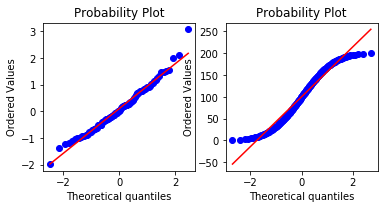

In [57]:
# generate a normal distribution for comparison
nr.seed(1357)
norm1 = nr.normal(size = 100).tolist()

# get price column as array excluding undefined, zero, and negative values
price = np.where(np.array(autoprice['price'].values) != '?')[0]
price = np.where(price > 0)[0]

# perform Q-Q plot of price
qq_plot(norm1, price)

Perform a Q-Q plot of *log(price)*:

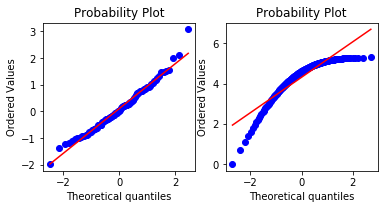

In [59]:
# compute log of 'price'
log_price = np.log(price)

# perform Q-Q plot of 'log_price'
qq_plot(norm1, log_price)

Neither *price* nor *log(price)* aligns with our Q-Q plot of normally-distributed sample data.

#### Graphical Method 2: Comparison of Cumulative Distribution Functions

Perform a normality test using a comparison plot of cumulative distribution functions on *price*:

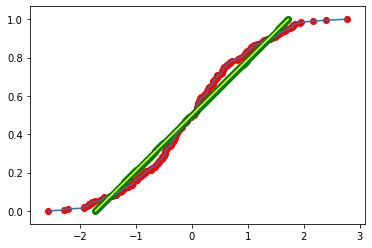

In [54]:
# generate a normal distribution with same length as 'price' for comparison
norm2 = nr.normal(size = len(price)).tolist()

# scale arrays
norm2_s = scale(norm2)
price_s = scale(price)

# plot comparison of cumulative distribution functions
plot_cums(norm2_s, price_s)

Perform a normality test using a comparison plot of cumulative distribution functions on *log(price)*:

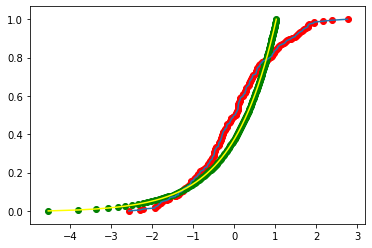

In [60]:
log_price_s = scale(log_price)

# plot comparison of cumulative distribution functions
plot_cums(norm2_s, log_price_s)

Neither *price* nor *log(price)* aligns with our plot of a normal cumulative distribution.

#### Formal Method: Kolmogorov-Smirnov Test

Now perform a formal test of normality, the Kolmogorov-Smirnov test, against *price*:

In [48]:
ks_test(price_s)

KS-statistic = 0.060967873459455535
P-value = 0.4311198551639826


The KS-statistic is small, though given the low p-value, we'd like it to be smaller to have sufficient confidence that the distribution is in fact normal. Therefore, it appears likely that the distribution of *price* is not normal.

Perform the Kolmogorov-Smimov test also against *log(price)*:

In [62]:
ks_test(log_price_s)

KS-statistic = 0.15113314252090237
P-value = 0.0001875562050121371


The KS-statistic for *log(price)* is larger than that for *price* and the p-value is tiny, suggesting that the distribution of *log(price)* is not normal.

### Testing the Significance of Price or log(Price) By 3 Categorical Variables

We shall test the significance of *price* by the variables a) *fuel-type*, b) *aspiration*, and c) *drive-wheels*.

First we begin with a comparison of means between groups within these variables.

#### Price of Diesel vs. Gas Autos

Perform a t-test and plot comparative histograms of respective prices of diesel and gas fuel types:

DegFreedom      23.610874
Difference    2921.741160
Statistic        1.594268
PValue           0.124176
Low95CI       -863.972314
High95CI      6707.454635
dtype: float64


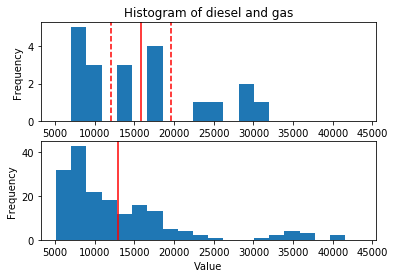

In [106]:
# extract groups
diesel = np.array(autoprice.loc[autoprice.loc[:, 'fuel-type'] == 'diesel', 'price'])
gas = np.array(autoprice.loc[autoprice.loc[:, 'fuel-type'] == 'gas', 'price'])

# eliminate unknown values
diesel = diesel[np.where(diesel != '?')]
gas = gas[np.where(gas != '?')]

# cast prices to numeric type
diesel = diesel.astype(int)
gas = gas.astype(int)

# perform t-test
test_fuel_type = t_test(diesel, gas, alpha = 0.05)
print(test_fuel_type)

# produce comparative plots
plot_t(diesel, gas, test_fuel_type, cols=['diesel', 'gas'])

There does not appear to be a meaningful difference in price between diesel and gas vehicles, though we note outliers in both distributions. The difference in means is fairly small suggesting that no real meaningful difference exists between groups. Meanwhile the t-statistic is low and the p-value is higher than we might prefer if there were a meaningful difference. Note also that the 95% confidence interval straddles 0, indicating that the possibility that there is no difference lies within the confidence interval.

#### Price of Standard vs. Turbo Autos

Perform a t-test and plot comparative histograms of respective prices of standard and turbo vehicles:

DegFreedom      47.960507
Difference   -1065.484848
Statistic       -0.647302
PValue           0.520523
Low95CI      -4375.137627
High95CI      2244.167931
dtype: float64


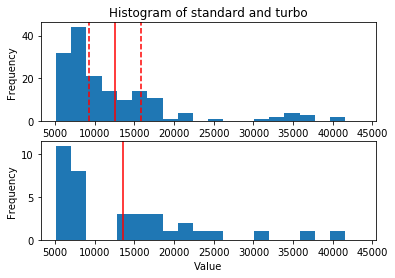

In [107]:
# extract groups
std = np.array(autoprice.loc[autoprice.loc[:, 'aspiration'] == 'std', 'price'])
turbo = np.array(autoprice.loc[autoprice.loc[:, 'aspiration'] == 'turbo', 'price'])

# eliminate unknown values
std = std[np.where(std != '?')]
turbo = gas[np.where(turbo != '?')]

# cast prices to numeric type
std = std.astype(int)
turbo = turbo.astype(int)

# perform t-test
test_aspiration = t_test(std, turbo, alpha = 0.05)
print(test_aspiration)

# produce comparative plots
plot_t(std, turbo, test_aspiration, cols=['standard', 'turbo'])

There does not appear to be a meaningful difference in price between standard and turbo vehicles, though again we note outliers in both distributions. The difference in means is quite small suggesting that no real meaningful difference exists between groups. Meanwhile the t-statistic is low and the p-value is high. Note that the 95% confidence interval straddles 0, indicating that the possibility that there is no difference lies within the confidence interval.

#### Price of Front- vs. Rear-Wheel Drive Autos

Perform a t-test and plot comparative histograms of respective prices of front- and rear-wheel drive vehicles. Note that we exclude four-wheel drive vehicles because this category has insufficient data for comparison:

DegFreedom    8.690742e+01
Difference   -1.051283e+04
Statistic    -9.617793e+00
PValue        2.464998e-15
Low95CI      -1.268544e+04
High95CI     -8.340224e+03
dtype: float64


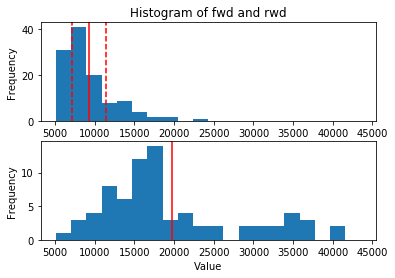

In [110]:
# extract groups
fwd = np.array(autoprice.loc[autoprice.loc[:, 'drive-wheels'] == 'fwd', 'price'])
rwd = np.array(autoprice.loc[autoprice.loc[:, 'drive-wheels'] == 'rwd', 'price'])

# eliminate unknown values
fwd = fwd[np.where(fwd != '?')]
rwd = rwd[np.where(rwd != '?')]

# cast prices to numeric type
fwd = fwd.astype(int)
rwd = rwd.astype(int)

# perform t-test
test_drive_wheels = t_test(fwd, rwd, alpha = 0.05)
print(test_drive_wheels)

# produce comparative plots
plot_t(fwd, rwd, test_drive_wheels, cols=['fwd', 'rwd'])

There appears to be a meaningful difference in price between front- vs. rear-wheel drive vehicles. The difference in means is substantial suggesting that a meaningful difference exists between groups. Meanwhile the t-statistic is large in the negative direction and the p-value is extremely low. Note also that the 95% confidence interval does not straddle 0, so the possibility that no difference exists does not lie within the confidence interval.

### Apply ANOVA and Tukey's HSD Test to Price by Body Style

We now apply ANOVA and Tukey's HSD test to categories of body style by price. Note that there is an insufficient number of convertibles to perform these tests.

In [116]:
# extract groups
hatchback = np.array(autoprice.loc[autoprice.loc[:, 'body-style'] == 'hatchback', 'price'])
sedan = np.array(autoprice.loc[autoprice.loc[:, 'body-style'] == 'sedan', 'price'])
wagon = np.array(autoprice.loc[autoprice.loc[:, 'body-style'] == 'wagon', 'price'])

# eliminate unknown values
hatchback = hatchback[np.where(hatchback != '?')]
sedan = sedan[np.where(sedan != '?')]
wagon = wagon[np.where(wagon != '?')]

# cast prices to numeric type
hatchback = hatchback.astype(int)
sedan = sedan.astype(int)
wagon = wagon.astype(int)

df = pd.DataFrame({'vals': hatchback.tolist() + sedan.tolist() + wagon.tolist(),
                   'group': ['hatchback'] * len(hatchback) + ['sedan'] * len(sedan) +
                  ['wagon'] * len(wagon)})
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group)
print(Tukey_HSD)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1  group2  meandiff  p-adj    lower      upper   reject
--------------------------------------------------------------
hatchback  sedan  4502.3141  0.001  1939.6669 7064.9614   True
hatchback  wagon  2414.5188 0.2865 -1350.4963 6179.5339  False
    sedan  wagon -2087.7953 0.3641 -5710.1357 1534.5451  False
--------------------------------------------------------------


Graphically, we can visualize:

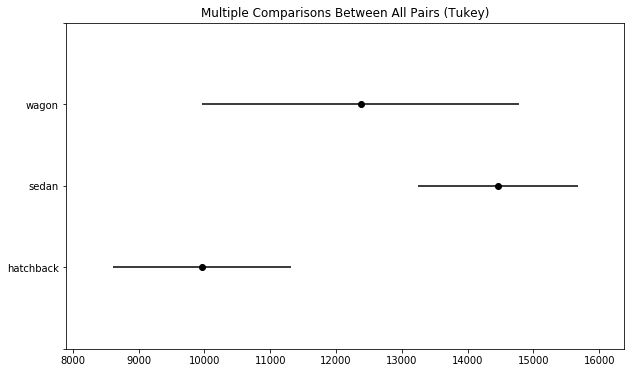

In [118]:
_ = Tukey_HSD.plot_simultaneous()

The test indicates that meaningful difference in price likely exists between hatchbacks and sedans (reject null hypothesis == True) where we find a notable difference between means but not between either of these categories and wagons (reject null hypothesis == False), where the difference in means is about half as much. Note that the confidence interval does not straddle zero (no difference) between hatchbacks and sedans, but does straddle zero between these categories and wagons. Meanwhile, the p-value between hatchbacks and sedans is quite low at 0.001, while the p-values between these categories and wagons is quite high. Finally, we observe that there is no overlap in the simultaneous plot between hatchbacks and sedans, but there is overlap between each of these categories and wagons.